# Quantile Regression

In this notebook, quantile regression is applied to determine feature correlation with the 75th quantile of curtailment. The model was chosen because the top quantile of curtailment is where there is most opportunity of green hydrogen production. 

A few changes were made for this Quantile Regression Notebook since PDL2. The model previously did not converge, but we were able to address that by increasing the max interations. The model now also produces a final quantile process plot focusing on the statistically significant features. Despite the changes, the order of operations in this notebook largely remains the same.

The notebook evaluates based on non-zero curtailment data. It first divides the data into quantiles. Pinball loss scores are  derived to show the accuracy of the quantile forecast, 
specifically in the high quantiles (0.75 and up), with smaller values (closer to 0) being tied to higher accuracy.It was found that at higher quantiles, the pinball loss score decreased. 

Then, we plotted predicted curtailment versus each feature across the higher quantiles of 0.75, 0.80, 0.85, 0.90, 0.95. The purpose of these plots was to get a better idea individually how each feature related to the curtailment level in various quantiles.

Next, Quantile Process Plots are producedfor each feature, showing the coefficient of the feature across each quantile level. With each coefficient point on the plot, the 95% confidence interval is also plotted. OLS is also mapped onto the plot to compare with OLS predictive results vs observed total curtailment. A summary table then shows the p-values of the features. Only 6 features were statistically significant: exports, total load, battery charging delta, battery charging state, spring, and summer. With this, a final Quantile Process Plot of these statistically signficant features is produced, showing the coefficients of each of these variables at each quantile level. Spring was a good example of a feature that had high coefficient values in the higher quantiles with smaller confidence intervals. This suggests that Spring is correlated with curtailment, likely due to an abundance of renewable energy during Spring and lower energy demand.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

import statsmodels.formula.api as smf
from sklearn.metrics import mean_pinball_loss
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler


In [ ]:
df_curtailment = pd.read_csv('final_data.csv')

In [ ]:
df_curtailment.head(n=5)

,Unnamed: 0,percent_wind_gen,percent_solar_gen,exports,total_load,total_lmp,battery_en,battery_soc,season_summer,season_spring,season_winter,solar_exports,total_curtailment
0,0,0.265874,0.0,-69960.360000,21302.162944,114.687870,41.976,6524.477167,0,0,1,-0.0,0.0
1,1,0.303146,0.0,-67462.573333,20803.750237,108.752210,-5.863,6460.896417,0,0,1,-0.0,0.0
2,2,0.327688,0.0,-65642.693333,20300.078086,102.776174,-54.224,6465.033667,0,0,1,-0.0,0.0
3,3,0.326433,0.0,-64974.106667,19914.921017,106.676475,19.609,6460.216500,0,0,1,-0.0,0.0
4,4,0.292937,0.0,-65427.986667,19975.842246,110.358796,8.992,6428.138083,0,0,1,-0.0,0.0


In [ ]:
print((df_curtailment['total_curtailment'] == 0).mean())

0.47001823985408114


In [ ]:
df = df_curtailment[df_curtailment['total_curtailment'] > 0]

#took out total solar, wind
X = df[['percent_wind_gen',
        'percent_solar_gen',
        'exports',
        'total_load',
        'total_lmp',
        'battery_en',
        'battery_soc',
        'season_summer',
        'season_spring',
        'season_winter',
        'solar_exports']] 

y = df['total_curtailment']

#scale so model converges
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=10) 

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#add constant
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

#focus on higher quantiles for peak curtailment periods
quantiles = [0.75, 0.8, 0.85, 0.90, 0.95]
models = {}
predictions = {}
pinball_losses = {}

for q in quantiles:
    mod = sm.QuantReg(y_train, X_train)

    res = mod.fit(q=q, max_iter = 20000)
    models[q] = res
    y_pred = res.predict(X_test)
    predictions[q] = y_pred

    # Evaluate using pinball loss
    loss = mean_pinball_loss(y_test, y_pred, alpha=q)
    pinball_losses[q] = loss
    print(f"Quantile {q}: Pinball Loss = {loss:.3f}")


Quantile 0.75: Pinball Loss = 3590.643
Quantile 0.8: Pinball Loss = 3382.293
Quantile 0.85: Pinball Loss = 3031.075
Quantile 0.9: Pinball Loss = 2464.973
Quantile 0.95: Pinball Loss = 1602.747


Model uses mean_pinball_loss to evaluate Quantile Regression models.
- measures accuracy of quantile forecast
- pinball loss score decreases as quantile increases.

In [ ]:
feature_names_map = {
    'percent_wind_gen': '% Wind Generation',
    'percent_solar_gen': '% Solar Generation',
    'exports': 'Exports',
    'total_load': 'Total Load',
    'total_lmp': 'LMP',
    'battery_en': 'Battery Charging Delta',
    'battery_soc': 'Battery Charge State',
    'season_summer': 'Summer',
    'season_spring': 'Spring',
    'season_winter': 'Winter',
    'solar_exports': 'Solar_Exports'
}

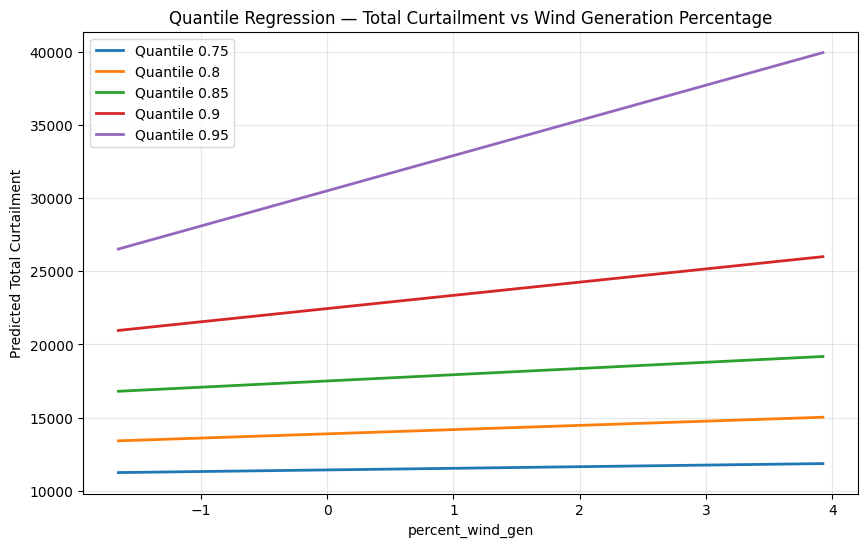

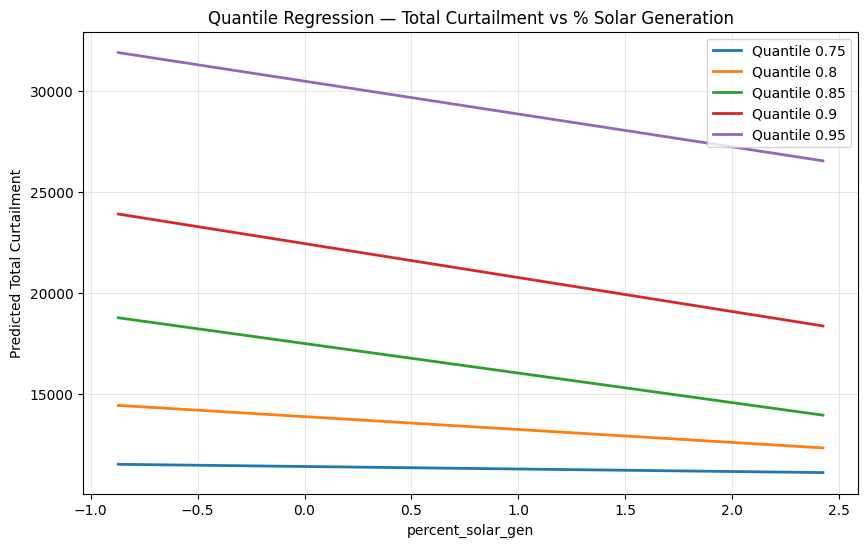

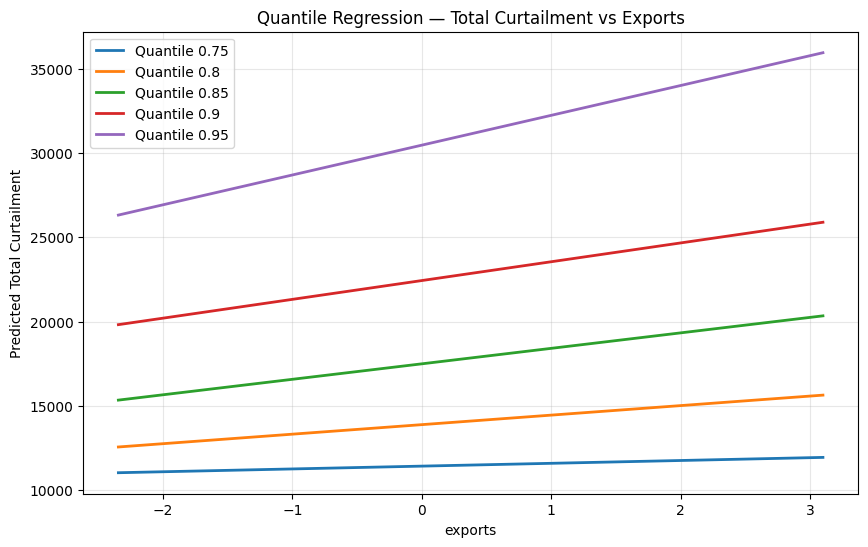

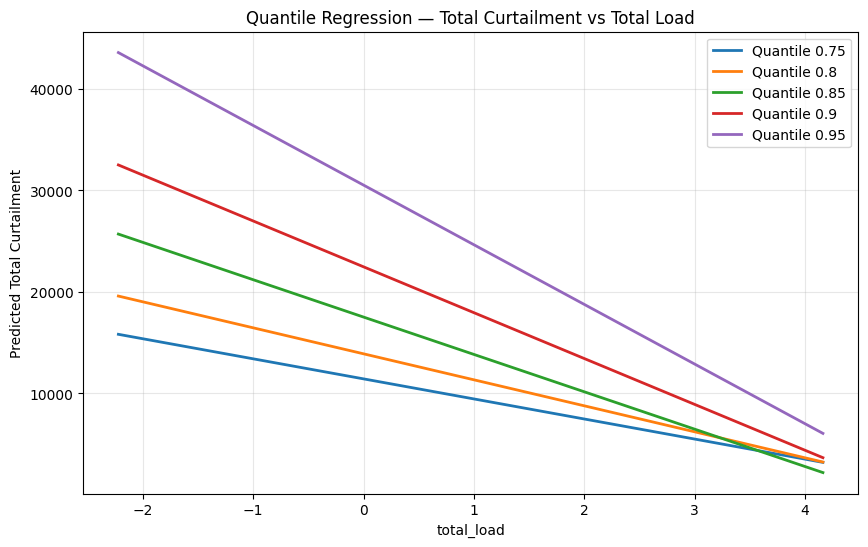

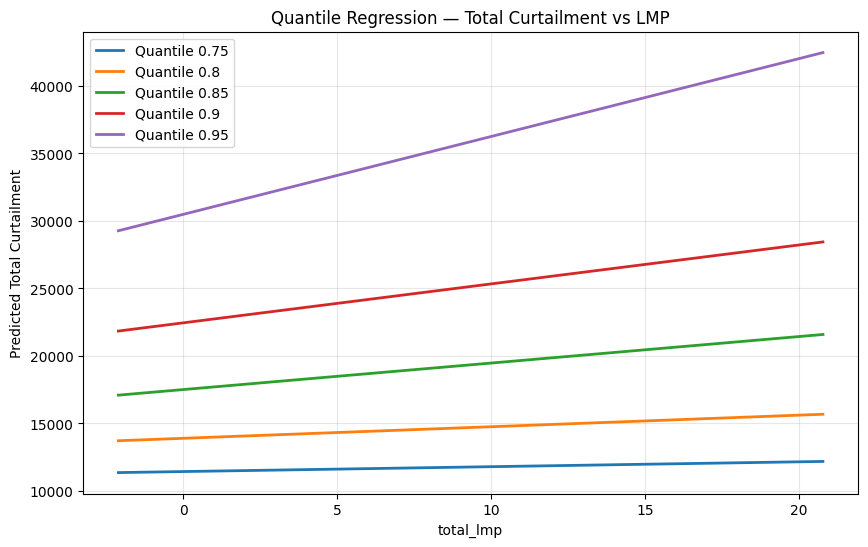

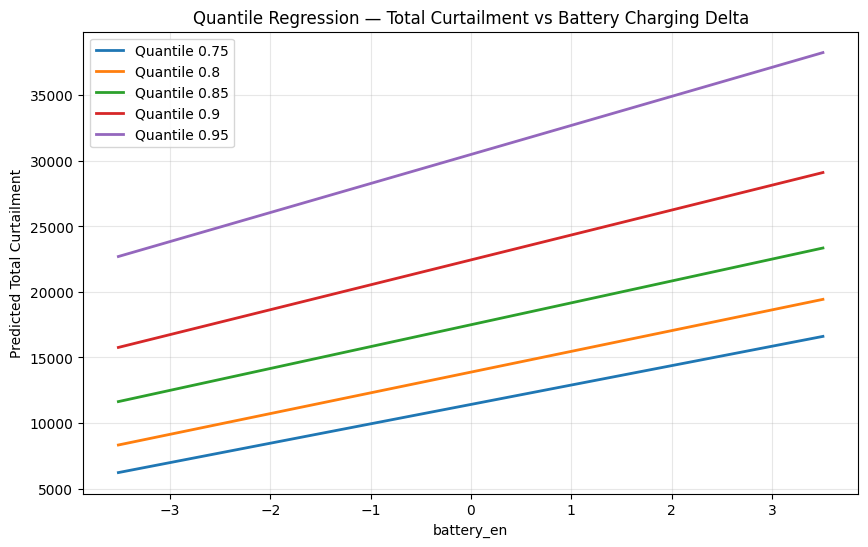

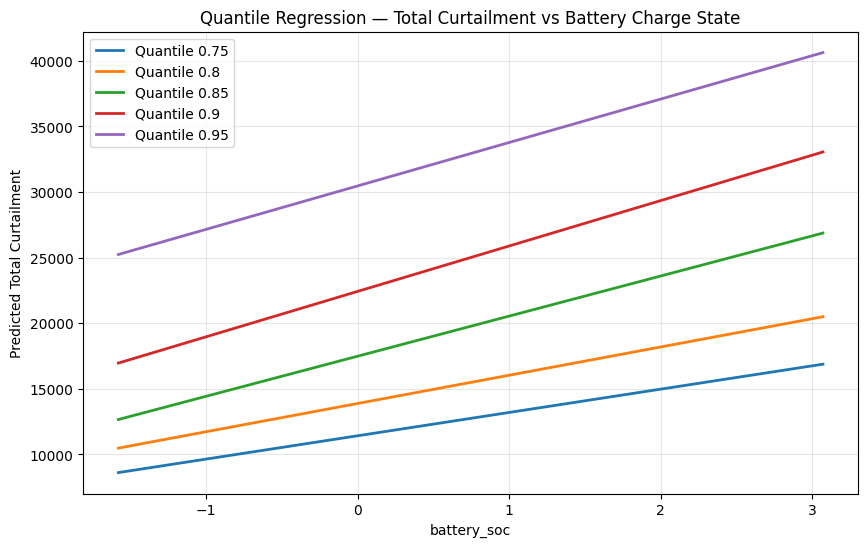

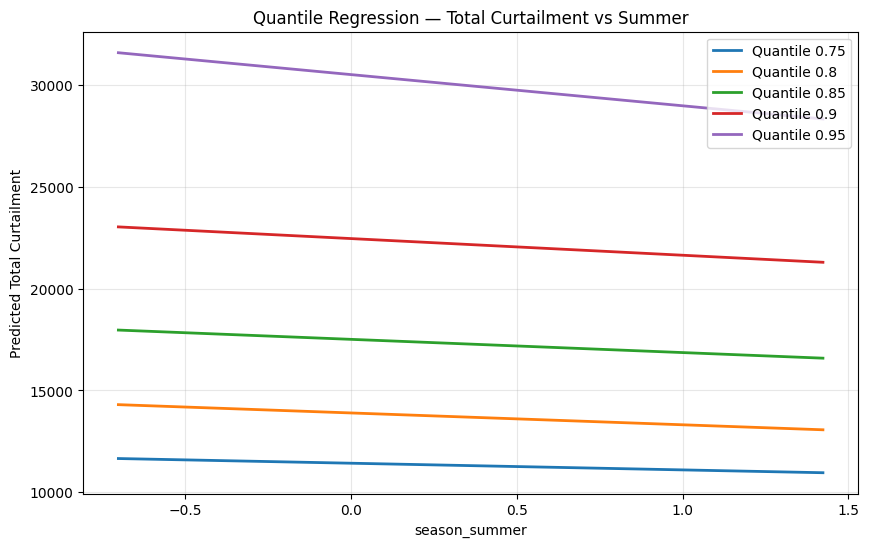

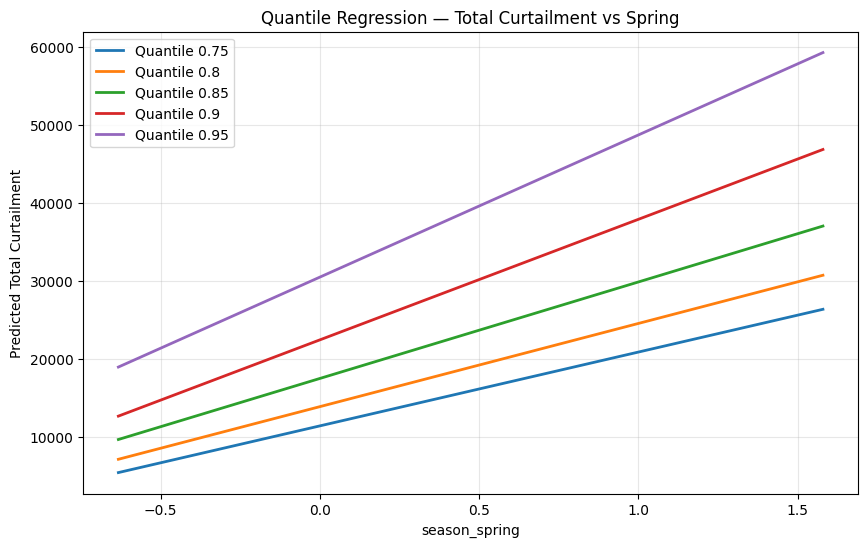

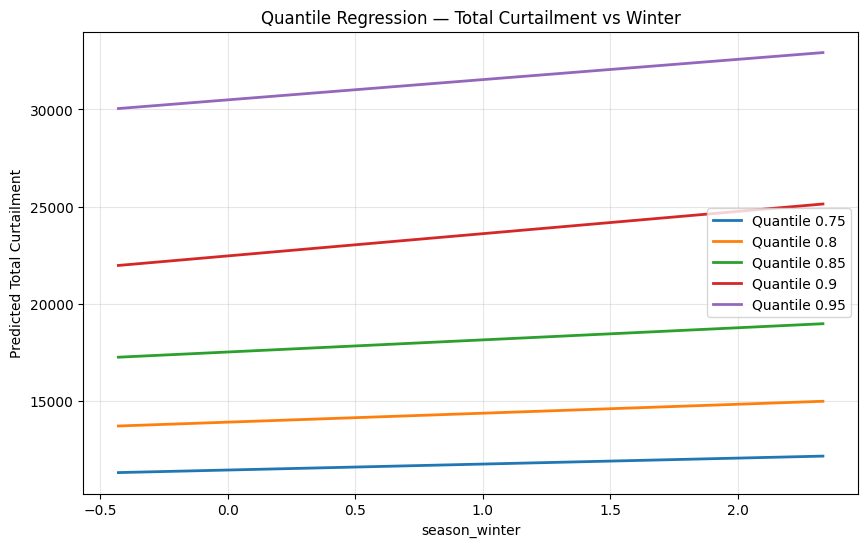

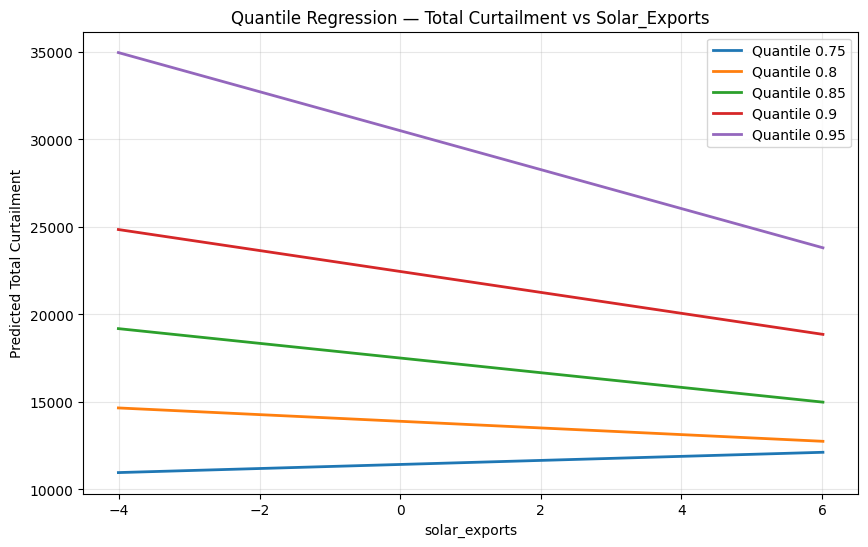

In [ ]:
other_means = X_train.mean()

features = ['percent_wind_gen', 'percent_solar_gen', 'exports',
            'total_load', 'total_lmp', 'battery_en', 'battery_soc',
            'season_summer', 'season_spring', 'season_winter','solar_exports']

for feature in features:

    descriptive_name = feature_names_map.get(feature, feature)
    plt.figure(figsize=(10,6))
    x_range = np.linspace(X_train[feature].min(), X_train[feature].max(), 100)

    for q, res in models.items():
        y_pred = (
            res.params['const']
            + res.params[feature] * x_range
            + sum(
                res.params[var] * other_means[var]
                for var in other_means.index
                if var not in ['const', feature]
            )
        )
        plt.plot(x_range, y_pred, label=f"Quantile {q}", linewidth=2)

    plt.title(f"Quantile Regression — Total Curtailment vs {descriptive_name}")
    plt.xlabel(feature)
    plt.ylabel("Predicted Total Curtailment")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


For each feature (like battery SOC, wind %, imports), see how predicted curtailment changes as that feature changes, while all other features stay fixed at their mean.

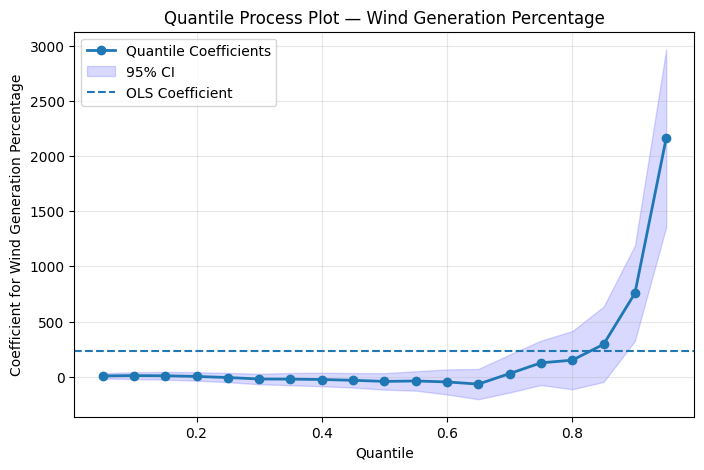

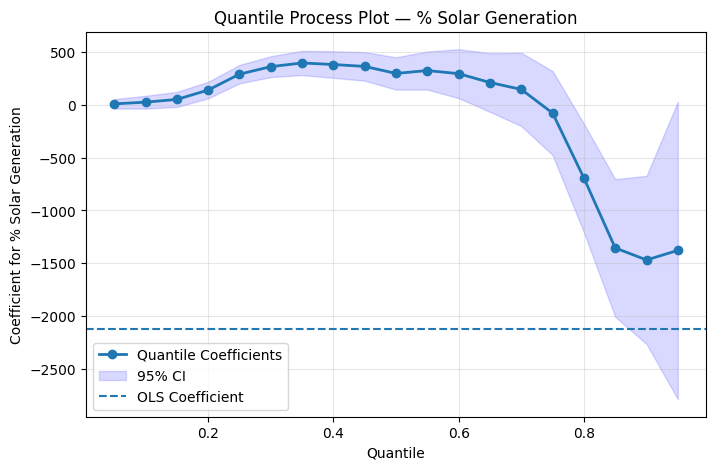

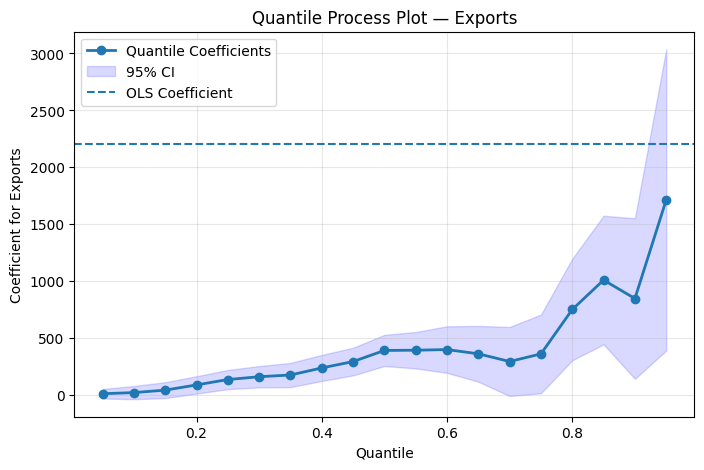

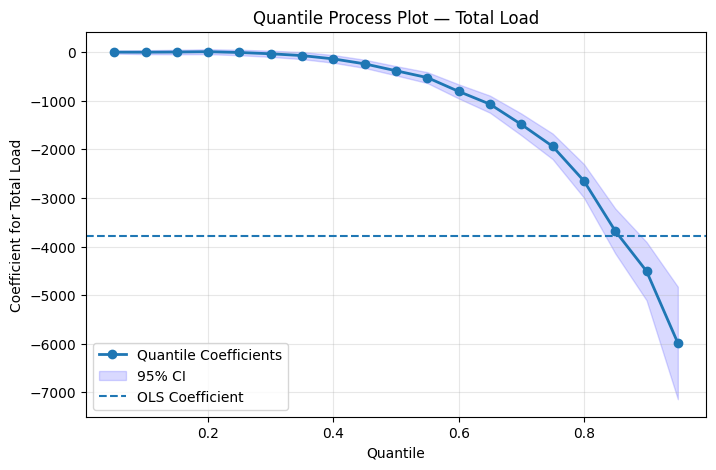

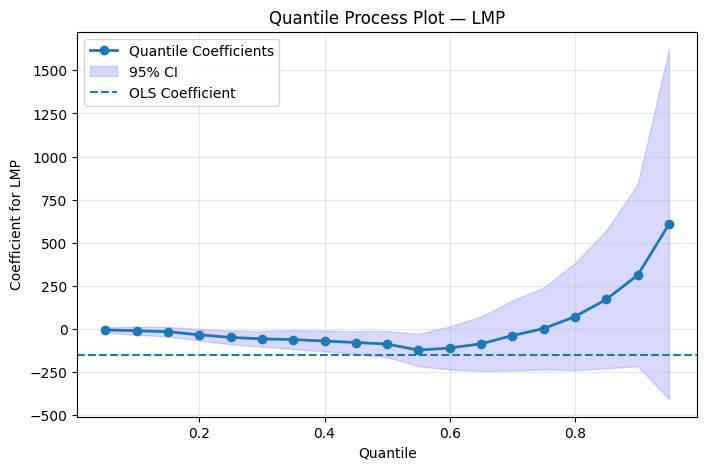

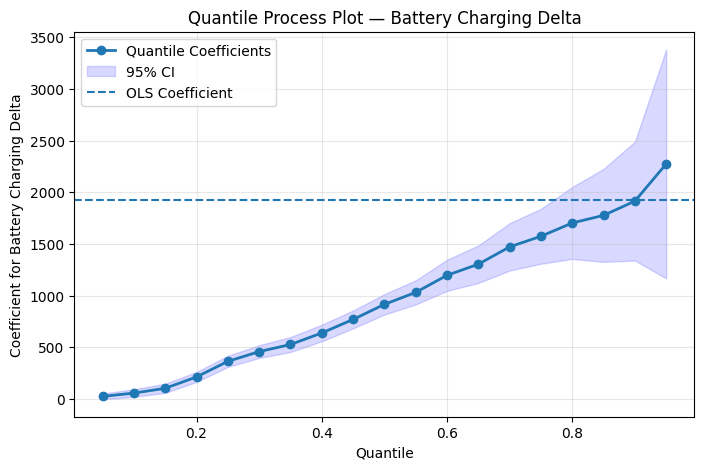

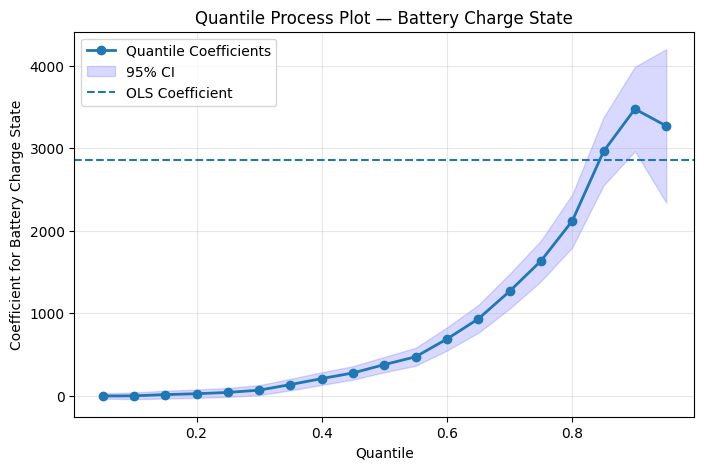

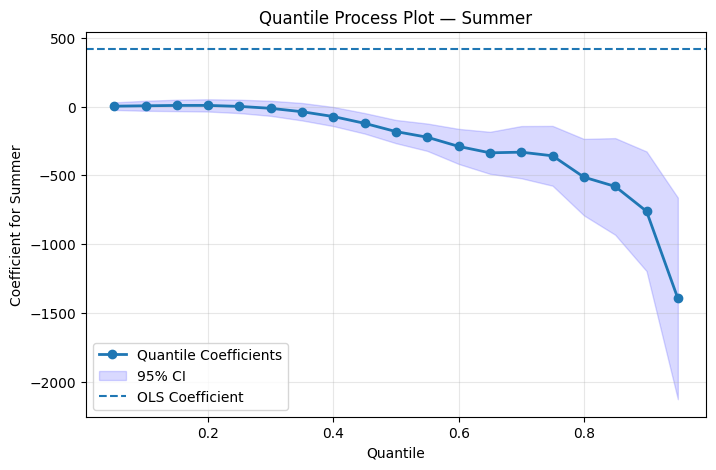

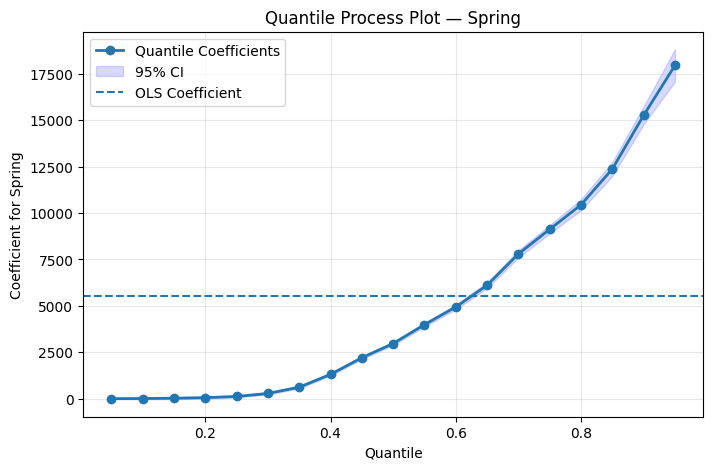

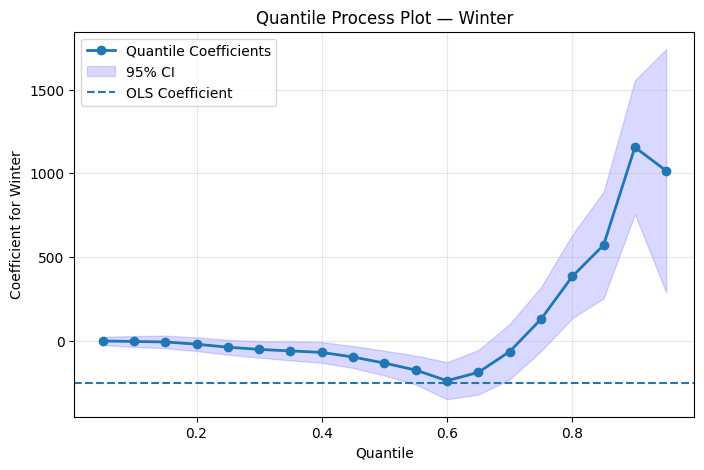

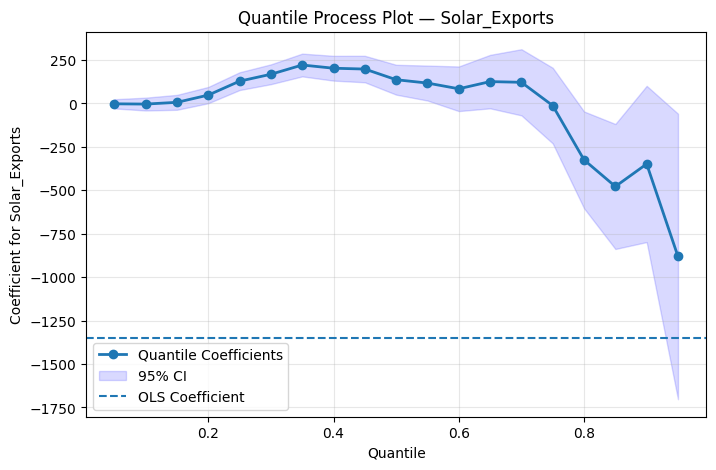

In [ ]:
X_scaled_with_const = sm.add_constant(X_scaled)
process_plot_quantiles = np.arange(0.05, 0.96, 0.05)
coef_dict = {feature: [] for feature in features}

se_dict = {feature: [] for feature in features} 
y = y.reset_index(drop=True)


for q in process_plot_quantiles:
    model = sm.QuantReg(y, X_scaled_with_const)
    res = model.fit(q=q, max_iter = 20000)

    for feature in coef_dict:
        coef_dict[feature].append(res.params[feature])
        se_dict[feature].append(res.bse[feature]) 


coef_df = pd.DataFrame(coef_dict, index=process_plot_quantiles)
se_df = pd.DataFrame(se_dict, index=process_plot_quantiles) 
Z = 1.96 

ols = sm.OLS(y, X_scaled_with_const).fit()
ols_params = ols.params

for feature in features:
    descriptive_name = feature_names_map.get(feature, feature)
    plt.figure(figsize=(8, 5))

    plt.plot(
        process_plot_quantiles,
        coef_df[feature],
        marker='o',
        label="Quantile Coefficients",
        linewidth=2
    )

    #lower, upper bounds for CI
    upper_bound = coef_df[feature] + Z * se_df[feature]
    lower_bound = coef_df[feature] - Z * se_df[feature]
    plt.fill_between(
        process_plot_quantiles,
        lower_bound,
        upper_bound,
        color='blue',
        alpha=0.15,
        label="95% CI"
    )


    #OLS
    plt.axhline(
        ols_params[feature],
        linestyle='--',
        label="OLS Coefficient"
    )

    plt.xlabel("Quantile")
    plt.ylabel(f"Coefficient for {descriptive_name}")
    plt.title(f"Quantile Process Plot — {descriptive_name}") 
    plt.grid(alpha=0.3)
    plt.legend(loc='best') 
    plt.show()

The graph has 2 parts.
1. How the feature’s coefficient changes as you move from low curtailment to high curtailment. Some coefficients are stronger in the high quantiles.
2. Comparing against OLS

Since OLS is the the average relationship for the feature and response, points higher than the OLS line represent that the model under-predicted.

In [ ]:
def bootstrap_ci(y, X, quantiles, features, B=100):
    boot_lower = {feature: [] for feature in features}
    boot_upper = {feature: [] for feature in features}

    n = len(y)

    for q in quantiles:
        coef_samples = {feature: [] for feature in features}

        for b in range(B):
            sample_idx = np.random.choice(n, n, replace=True)
            y_b = y.iloc[sample_idx]
            X_b = X.iloc[sample_idx]

            try:
                res_b = sm.QuantReg(y_b, X_b).fit(q=q, max_iter=20000, disp=False)
                for feature in features:
                    coef_samples[feature].append(res_b.params[feature])
            except:
                continue

        for feature in features:
            boot_lower[feature].append(np.percentile(coef_samples[feature], 2.5))
            boot_upper[feature].append(np.percentile(coef_samples[feature], 97.5))

    return boot_lower, boot_upper

In [ ]:
q75 = 0.75
model_75 = sm.QuantReg(y, X_scaled_with_const)
res_75 = model_75.fit(q=q75, max_iter=50000)

print(res_75.summary())

boot_lower_75, boot_upper_75 = bootstrap_ci(
    y=y,
    X=X_scaled_with_const,
    quantiles=[0.75],
    features=features,
    B=100
)

#bootstrapped confidence intervals - it was noted from presentation comments that bootstrapping was unnecessary. Code is here but left out of our analysis.
#for feature in features:
    #print(feature, boot_lower_75[feature][0], boot_upper_75[feature][0])


                         QuantReg Regression Results                          
Dep. Variable:      total_curtailment   Pseudo R-squared:               0.2173
Model:                       QuantReg   Bandwidth:                       1064.
Method:                 Least Squares   Sparsity:                    1.737e+04
Date:                Wed, 17 Dec 2025   No. Observations:                 9298
Time:                        03:14:45   Df Residuals:                     9286
                                        Df Model:                           11
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.117e+04     78.061    143.047      0.000     1.1e+04    1.13e+04
percent_wind_gen    125.6652    102.626      1.224      0.221     -75.505     326.835
percent_solar_gen   -78.9198    202.856     -0.389      0.697    -476.562     318.722
exports          

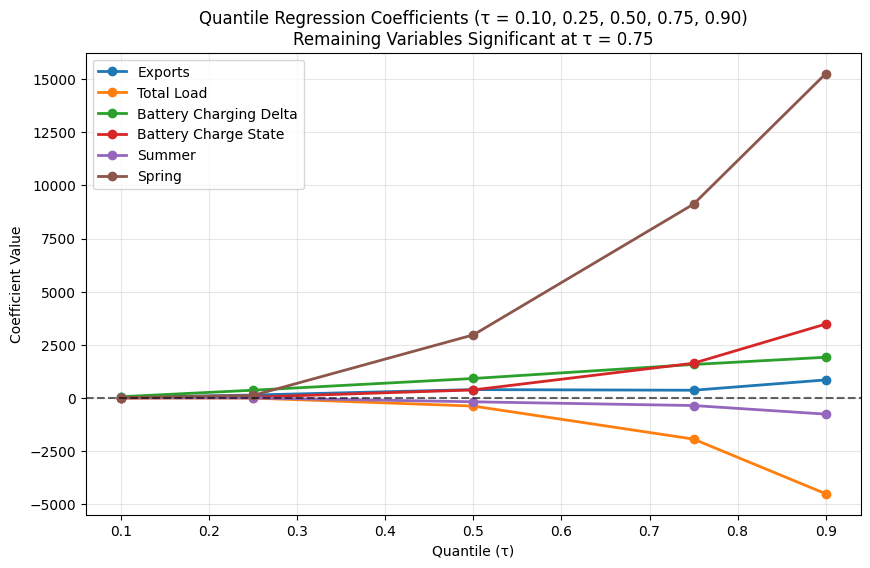

In [ ]:
plot_quantiles = [0.10, 0.25, 0.50, 0.75, 0.90]

significant_features = [
    'exports',
    'total_load',
    'battery_en',
    'battery_soc',
    'season_summer',
    'season_spring'
]

coef_store = {feature: [] for feature in significant_features}

for q in plot_quantiles:
    model = sm.QuantReg(y, X_scaled_with_const)
    res = model.fit(q=q, max_iter=50000)

    for feature in significant_features:
        coef_store[feature].append(res.params[feature])

coef_df = pd.DataFrame(coef_store, index=plot_quantiles)


plt.figure(figsize=(10, 6))

for feature in significant_features:
    plt.plot(
        plot_quantiles,
        coef_df[feature],
        marker='o',
        linewidth=2,
        label=feature_names_map.get(feature, feature)
    )

plt.axhline(0, linestyle='--', color='black', alpha=0.6)

plt.xlabel("Quantile (τ)")
plt.ylabel("Coefficient Value")
plt.title(
    "Quantile Regression Coefficients (τ = 0.10, 0.25, 0.50, 0.75, 0.90)\n"
    "Remaining Variables Significant at τ = 0.75"
)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

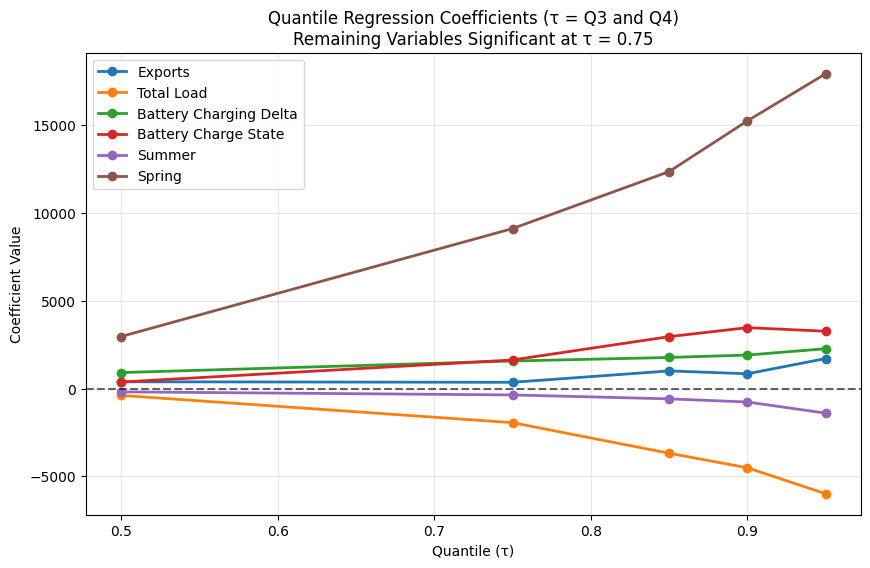

In [ ]:
plot_quantiles50 = [0.50, 0.75, 0.85, 0.90, 0.95]
coef_store50 = {feature: [] for feature in significant_features}

for q in plot_quantiles50:
    model = sm.QuantReg(y, X_scaled_with_const)
    res = model.fit(q=q, max_iter=50000)

    for feature in significant_features:
        coef_store50[feature].append(res.params[feature])

coef_df50 = pd.DataFrame(coef_store50, index=plot_quantiles50)

plt.figure(figsize=(10, 6))

for feature in significant_features:
    plt.plot(
        plot_quantiles50,
        coef_df50[feature],
        marker='o',
        linewidth=2,
        label=feature_names_map.get(feature, feature)
    )

plt.axhline(0, linestyle='--', color='black', alpha=0.6)

plt.xlabel("Quantile (τ)")
plt.ylabel("Coefficient Value")
plt.title(
    "Quantile Regression Coefficients (τ = Q3 and Q4)\n"
    "Remaining Variables Significant at τ = 0.75"
)
plt.grid(alpha=0.3)
plt.legend()
plt.show()